# Example notebook SUMup density
Author: Baptiste Vandecrux
Email: bav@geus.dk

**Content:**
* [Opening netcdf file and plotting latitude and longitudes](#1.1)
* [Plotting the 10 first profiles](#1.2)
* [Filtering southern profiles by location](#2.1)
* [Plotting the 10 first southern profiles](#2.2)
* [Finding the closest profile to a list of coordinates](#3.1)
* [Plotting the closest profiles selected](#3.2)



## 1.1 Opening netcdf file and plotting latitude and longitudes <a class="anchor" id="1.1"></a>


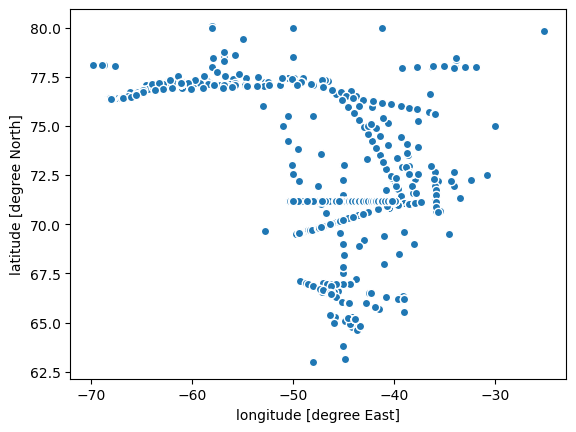

In [1]:
"""
SUMup example notebook: Density
@author: bav@geus.dk

"""

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

ds_density = xr.open_dataset('../SUMup 2023 beta/density/SUMup_2023_greenland_density.nc')

metadata_fields = ['profile_key', 'latitude','longitude','elevation',
                   'profile_name','reference','reference_short','method']
# separating data and metadata
ds_meta = ds_density[metadata_fields].rename({'profile_key':'profile'})
ds_density = ds_density.drop(metadata_fields)

# %% plotting latitude lontgitudes
plt.close('all')
plt.figure()
ds_meta[['latitude','longitude']].plot.scatter(x='longitude',y='latitude')


## 1.2 Plotting the 10 first profiles <a class="anchor" id="1.2"></a>

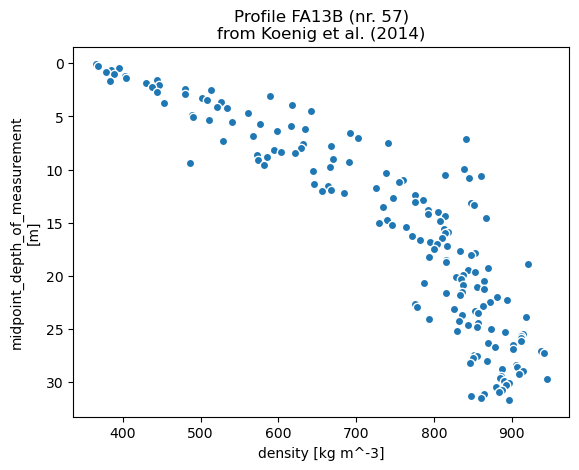

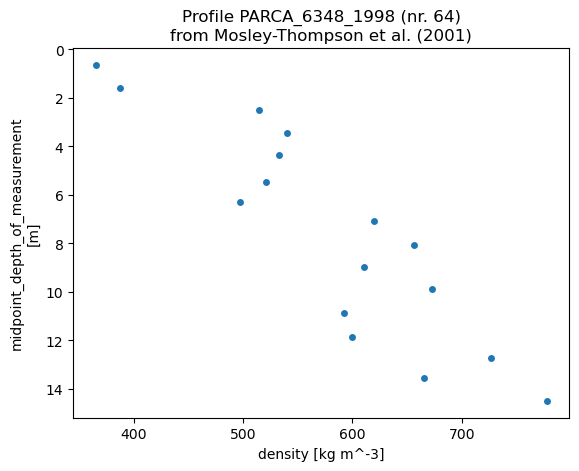

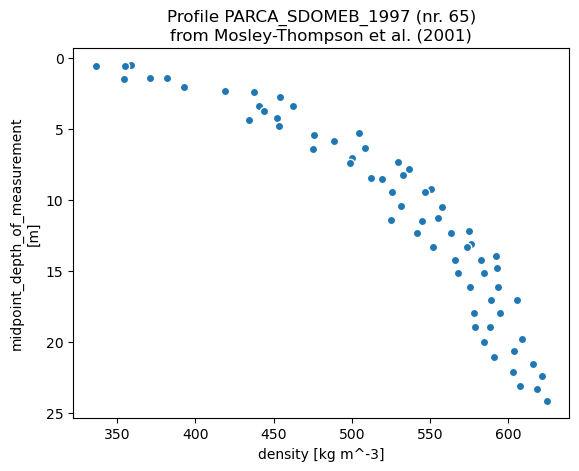

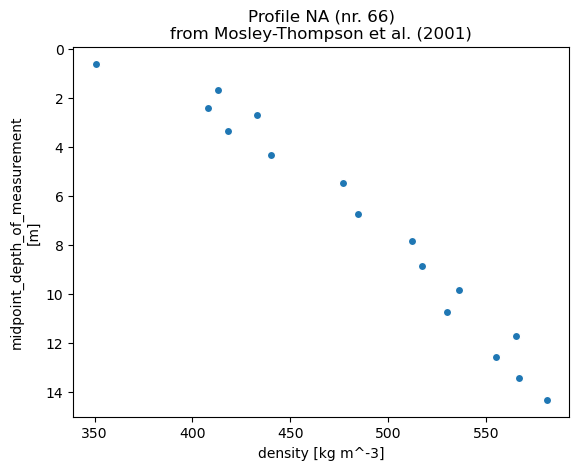

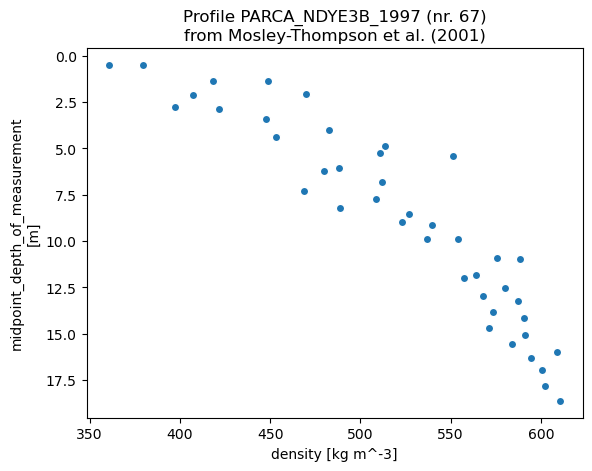

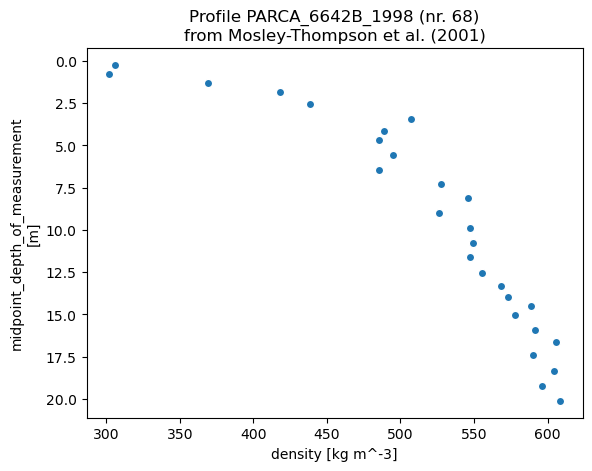

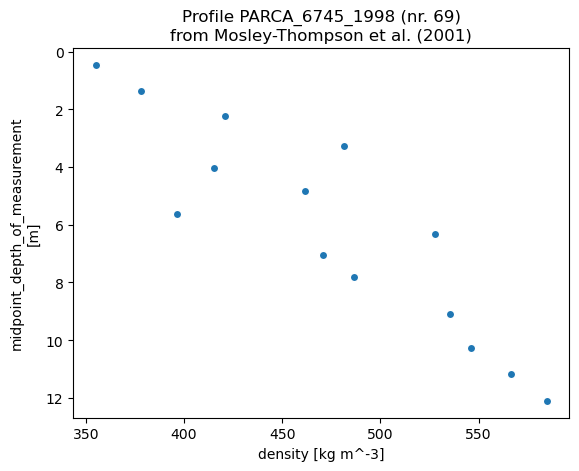

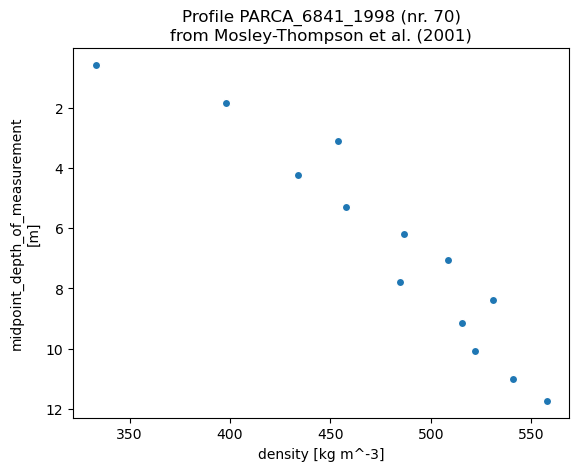

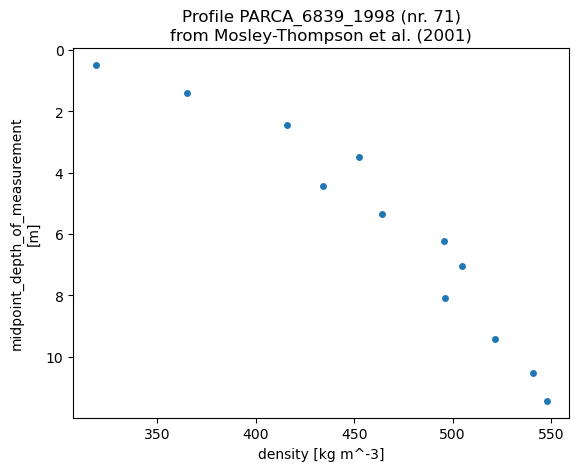

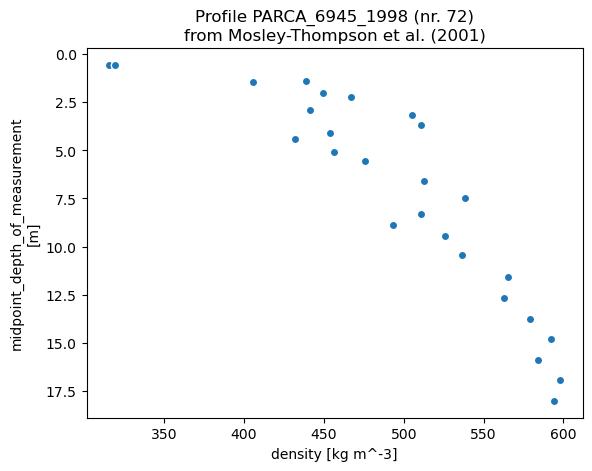

In [2]:

# %% plotting the 10 first profiles
for ind in ds_meta.profile[:10]:
    plt.figure()
    ds_density[
            ['density', 'midpoint', 'profile']
        ].where(ds_density.profile==ind).plot.scatter(
            x='density', 
            y='midpoint',
            yincrease=False,
            )
    plt.title(
        "Profile %s (nr. %i)\nfrom %s"%(
            ds_meta.profile_name.sel(profile=ind).values,
            ind,
            ds_meta.reference_short.sel(profile=ind).values
            ))

## 2.1 Filtering southern profiles by location <a class="anchor" id="2.1"></a>

<xarray.Dataset>
Dimensions:          (profile: 122)
Coordinates:
  * profile          (profile) float64 57.0 64.0 65.0 ... 2.359e+03 2.437e+03
Data variables:
    latitude         (profile) float32 66.18 63.0 63.15 ... 65.18 65.18 66.47
    longitude        (profile) float32 -39.04 -48.0 -44.82 ... -43.83 -46.28
    elevation        (profile) float64 1.563e+03 1.96e+03 ... 2.119e+03
    profile_name     (profile) object FA13B PARCA_6348_1998 ... DYE-2
    reference        (profile) object Koenig, L., C. Miege, R. R. Forster, an...
    reference_short  (profile) object Koenig et al. (2014) ... Reed (1966)
    method           (profile) object ice or firn core section ... 
Attributes:
    title:            SUMup density dataset for the Greenland ice sheet (2023...
    contact:          Baptiste Vandecrux
    email:            bav@geus.dk
    production date:  2023-09-05


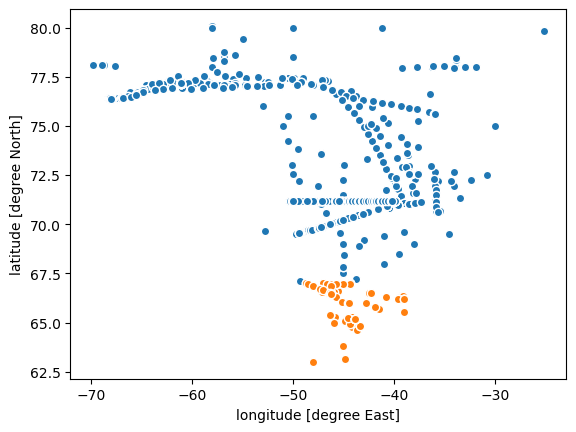

In [3]:
# %% filtering by location
# lets select the profiles tha are south of 67 deg N
ds_meta_south = ds_meta.where(ds_meta.latitude < 67, drop=True)

print(ds_meta_south)

plt.figure()
ds_meta[['latitude','longitude']].plot.scatter(x='longitude',y='latitude')
ds_meta_south[['latitude','longitude']].plot.scatter(x='longitude',y='latitude')

# we can isolate the density data for those southern profiles
ds_density_south = ds_density.where(
    ds_density.profile.isin(ds_meta_south.profile), 
    drop = True)
# but we could also continue with ds_density and only use profiles from ds_meta_south



## 2.2. Plotting the 10 first southern profiles  <a class="anchor" id="2.2"></a>

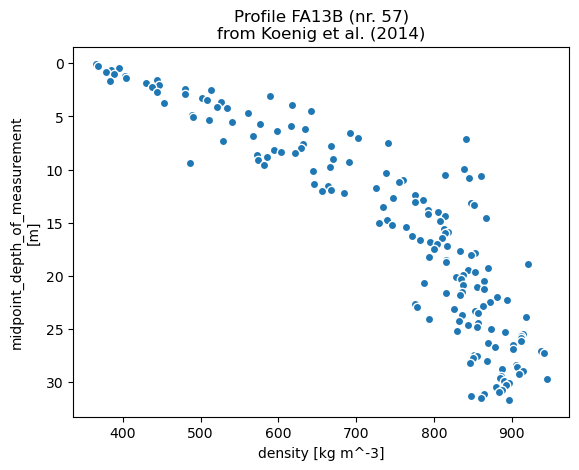

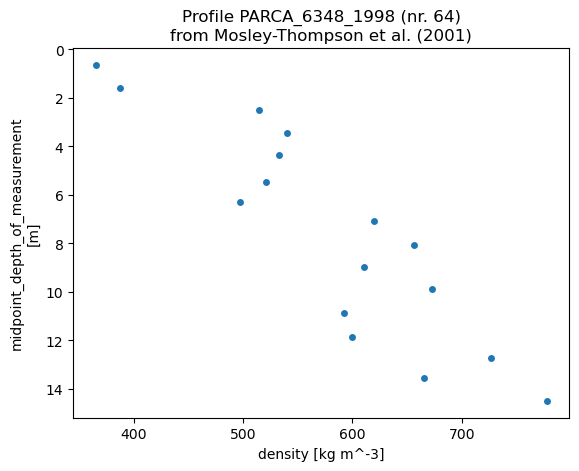

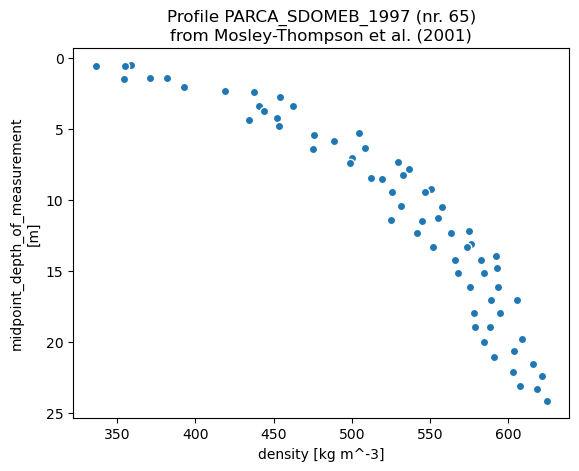

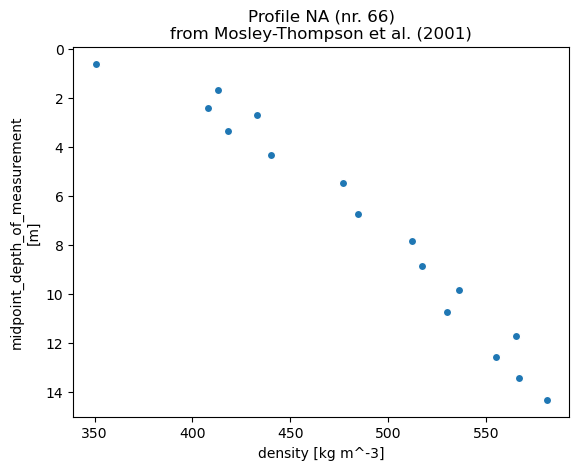

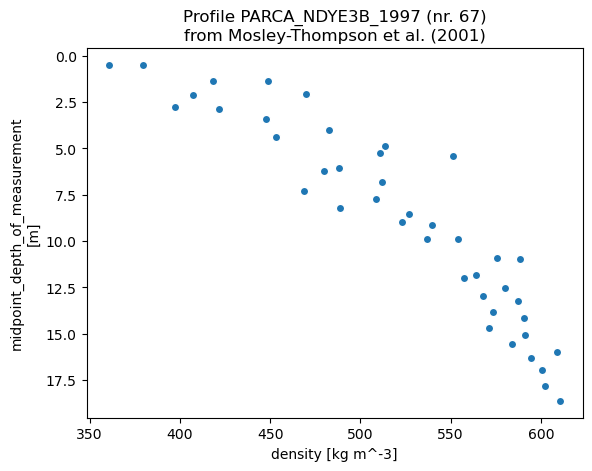

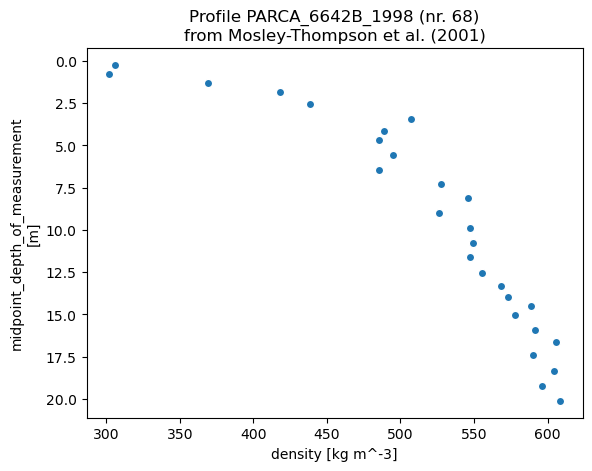

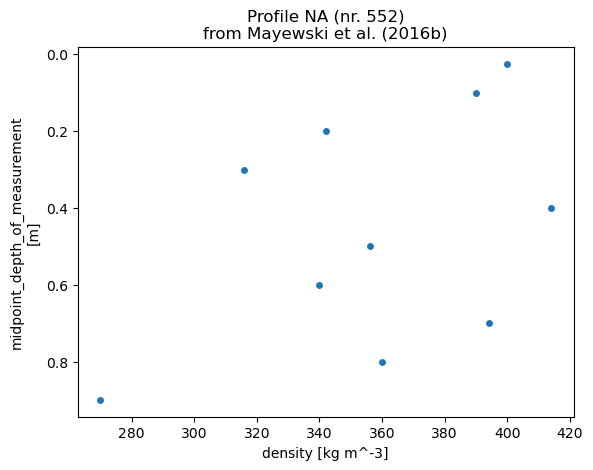

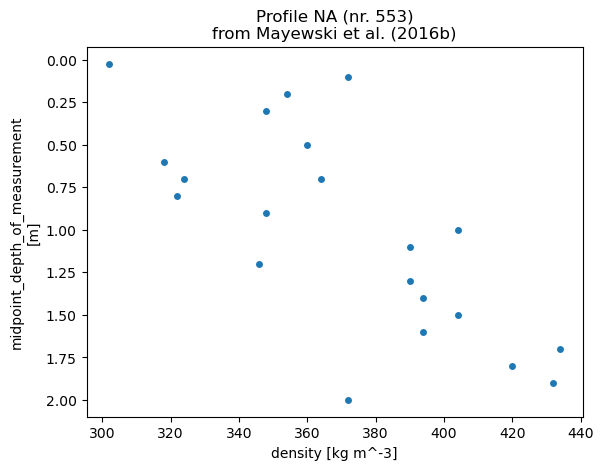

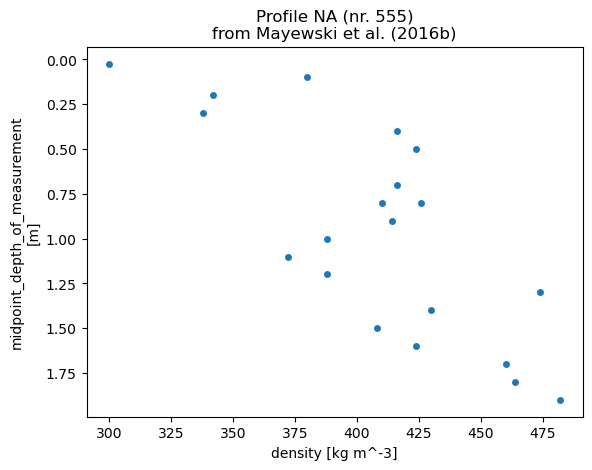

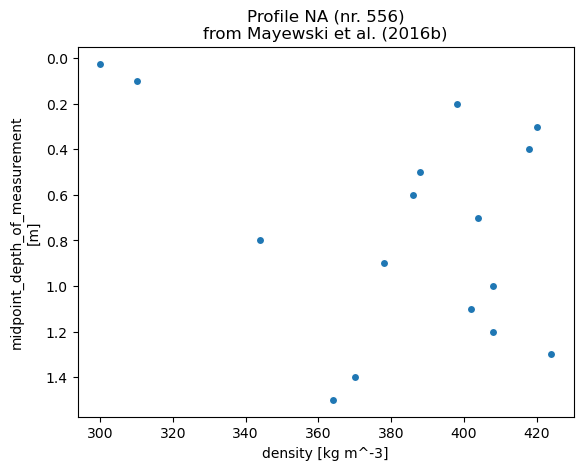

In [4]:
# %% plotting the 10 first southern profiles
for ind in ds_meta_south.profile[:10]:
    plt.figure()
    ds_density[
            ['density', 'midpoint', 'profile']
        ].where(ds_density.profile==ind).plot.scatter(
            x='density', 
            y='midpoint',
            yincrease=False,
            )
    plt.title(
        "Profile %s (nr. %i)\nfrom %s"%(
            ds_meta.profile_name.sel(profile=ind).values,
            ind,
            ds_meta.reference_short.sel(profile=ind).values
            ))

## 3.1 Finding the closest profile to a list of coordinates <a class="anchor" id="3.1"></a>

(71, -45) closest to profile 865  (71.1893°N, -44.8627°E) 21.6328 km away
(68, -45) closest to profile 479  (67.8306°N, -45.0936°E) 19.2484 km away
(77, -55) closest to profile 71  (77.0667°N, -54.7500°E) 9.6897 km away
(76, -38) closest to profile 286  (75.8585°N, -37.6974°E) 17.7427 km away


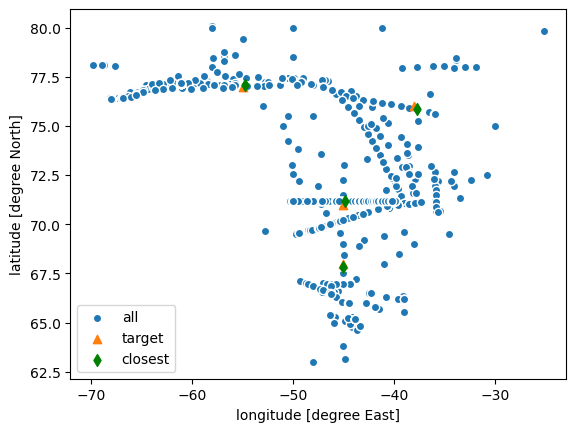

In [5]:
# %% finding the closest profile to given coordinates
# easiest if you use the following function
def nearest_latlon_profile(ds, points, return_value=True):
    # inspired from https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/Nearest_lat-lon_Grid.ipynb

    if 'lat' in ds: ds = ds.rename(dict(lat='latitude', lon='longitude'))
    if isinstance(points, tuple): points = [points]
        
    xs = []; distances = []  # distance between the pair of points
    
    for point in points:
        assert len(point) == 2, "``points`` should be a tuple or list of tuples (lat, lon)"
        
        p_lat, p_lon = point
        # Find absolute difference between requested point and the grid coordinates.
        abslat = np.abs(ds.latitude - p_lat)
        abslon = np.abs(ds.longitude - p_lon)

        # Create grid of the maximum values of the two absolute grids
        c = np.maximum(abslon, abslat)

        # Find location where lat/lon minimum absolute value intersects
        x = np.where(c == np.min(c))[0][0]
        xs.append(x)

        # Matched Grid lat/lon
        g_lat = ds.latitude.isel(profile=x).values
        g_lon = ds.longitude.isel(profile=x).values
               
        R = 6373.0  # approximate radius of earth in km

        lat1 = np.deg2rad(p_lat); lon1 = np.deg2rad(p_lon)
        lat2 = np.deg2rad(g_lat); lon2 = np.deg2rad(g_lon)
        dlon = lon2 - lon1; dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        distance = R * c
        distances.append(distance)
        print(point, 'closest to profile',x,' (%0.4f°N, %0.4f°E) %0.4f km away'%(
            g_lat, g_lon, R * c))
    return ds.profile.isel(profile=xs).values
    
coord_list = [(71, -45), (68, -45), (77, -55), (76, -38)]
ind_list = nearest_latlon_profile(ds_meta, coord_list)

# plotting coordinates
plt.figure()
ds_meta[['latitude','longitude']].plot.scatter(x='longitude',
                                               y='latitude',
                                               label='all')
plt.scatter(np.array(coord_list)[:,1],
            np.array(coord_list)[:,0], 
            marker='^', 
            label='target')
# note that normally ds_meta.sel(profile=ind) should work but there is currently
# problems with duplicate entries. The following should work anyway.
ds_meta.where(
    ds_meta.profile.isin(ind_list),
    drop = True
    )[
      ['latitude','longitude']
      ].plot.scatter(x='longitude',
                     y='latitude',
                     label='closest',
                     marker='d',
                     color='green')
plt.legend()


## 3.2 Plotting the closest profiles selected <a class="anchor" id="3.2"></a>

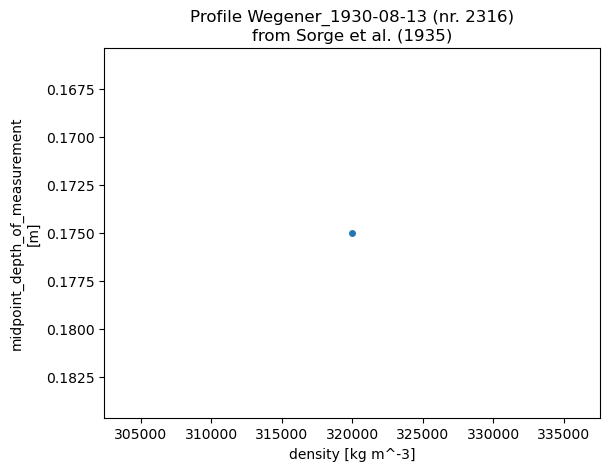

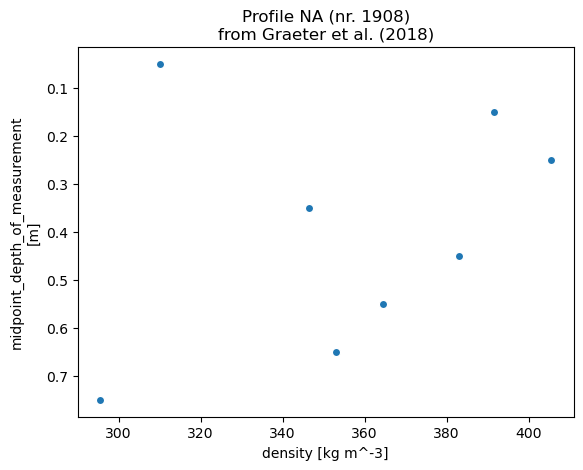

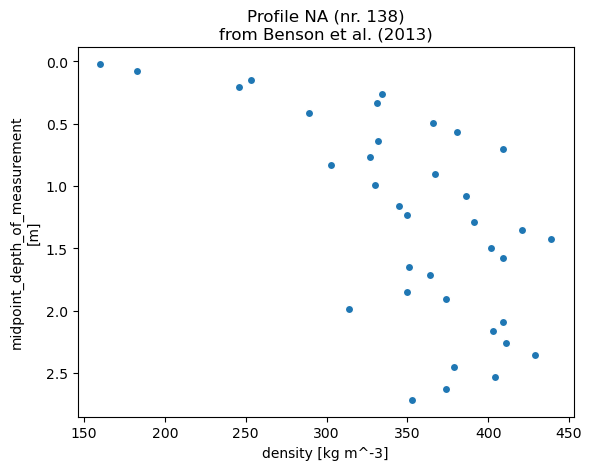

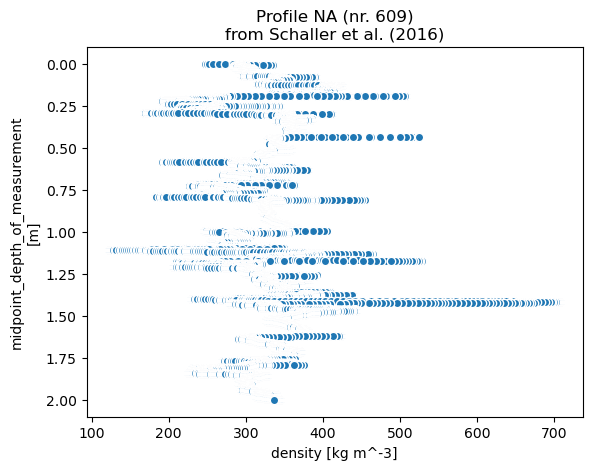

In [6]:

for ind in ind_list:
    plt.figure()
    ds_density[
            ['density', 'midpoint', 'profile']
        ].where(ds_density.profile==ind).plot.scatter(
            x='density', 
            y='midpoint',
            yincrease=False,
            )
    plt.title(
        "Profile %s (nr. %i)\nfrom %s"%(
            ds_meta.profile_name.sel(profile=ind).values,
            ind,
            ds_meta.reference_short.sel(profile=ind).values
            ))